In [1]:

import os
import ast
import json
import math
import time
import pickle
import random
import urllib

import numpy as np
import pandas as pd
import requests as req

from copy import copy
from tqdm import tqdm


PLAYER_PATH = 'D://_G_Street/player_model'
DROPBOX_PATH = 'C:\\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data'

def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di


teams = load_dict(os.path.join(DROPBOX_PATH, 'IDs/teams'))
competitions = load_dict(os.path.join(DROPBOX_PATH, 'IDs/competitions'))


In [2]:


def load_schedules():
    
    normal = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/processed_schedule.csv'))
    stf = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/stf_schedule.csv'))
    
    normal['datetime_UTC'] = pd.to_datetime(normal['datetime_UTC'].copy())
    stf['datetime_UTC'] = pd.to_datetime(stf['datetime_UTC'].copy())

    normal['match_date_UTC'] = normal['datetime_UTC'].copy().dt.date
    stf['match_date_UTC'] = stf['datetime_UTC'].copy().dt.date
    
    normal['last_updated'] = pd.to_datetime(normal['last_updated'].copy())
    stf['last_updated'] = pd.to_datetime(stf['last_updated'].copy())
    
    normal = normal.loc[~normal['match_status'].isin(['deleted','collecting','cancelled','postponed'])].reset_index(drop=True)
    stf = stf.loc[~stf['match_status'].isin(['deleted','collecting','cancelled','postponed'])].reset_index(drop=True)
    
    return normal, stf 


def EST_to_UTC(time):
    return time + pd.Timedelta(hours=5)

def statsbomb_to_UTC(time):
    return time - pd.Timedelta(hours=1)

def add_STF_info(cklst):
    
    cklst['STF'] = False
    cklst['stf_path'] = cklst.apply(lambda x: os.path.join(DROPBOX_PATH, f'Statsbomb/STF/{x.competition_id}/{x.season_id}/{x.match_id}-{x.team_id}.csv'), axis=1)
    # see if its a new game that doesn't exist yet
    cklst['STF'] = cklst.apply(lambda x: os.path.exists(x.stf_path), axis=1)
    cklst['as_path'] = cklst.apply(lambda x: os.path.join(DROPBOX_PATH, f'Statsbomb/atomic_sparse/{x.competition_id}/{x.season_id}/{x.match_id}.csv'), axis=1)
    return cklst


def add_game_clock(game):
    
    game['time'] = game['minute'].copy() + (game['second'].copy()/60)
    to_add = game.groupby(['period'])['time'].max().to_dict()
    to_add[0] = 45
    game['previous_period'] = game['period'].copy() - 1
    game['to_add'] = game['previous_period'].map(to_add)
    game['time'] = game['time'].copy() + game['to_add'].copy() - 45
    
    return game.drop(columns=['previous_period','to_add'])


def add_subs(game, lineup_df):
    
    subs = game.loc[game['type_id']==19].copy().reset_index(drop=True)
    subs = subs[['team_id','player_id','time','substitution_replacement_id','substitution_replacement_name','outcome_id','outcome_name']].copy()
    
    to_append = []
    for index,row in subs.iterrows():
        player_index = lineup_df[lineup_df['player_id']==row['player_id']].index
        if len(player_index)>0:
            player_index = player_index[0]
        else:
            continue
        lineup_df.at[player_index, 'end_time'] = row['time']
        lineup_df.at[player_index, 'sub_type'] = str(row['outcome_name']) + '_off'
        to_append.append(pd.DataFrame([[np.nan, row['substitution_replacement_id'], row['substitution_replacement_name'], 
        np.nan, np.nan, row['team_id'],  row['time'], game['time'].max(), str(row['outcome_name'])+'_on']], columns=list(lineup_df)))
        
    to_append = pd.concat(to_append, axis=0).reset_index(drop=True)
    lineup_df = pd.concat([lineup_df,to_append], axis=0).reset_index(drop=True)

    return lineup_df

def add_red_cards(game, lineup_df):
    # and 10 man injury, second yellows
    
    if 'player_off_permanent' in list(game):
        injury_loss = (game.player_off_permanent==True)
    else:
        injury_loss = (game.type_id==99999) # just creating falses
    if 'bad_behaviour_card_id' in list(game):
        bad_behave_red = (game.bad_behaviour_card_id==5)
        bad_behave_sy = (game.bad_behaviour_card_id==6)
    else:
        bad_behave_red = (game.type_id==99999) # just creating falses
        bad_behave_sy = (game.type_id==99999)
        
    if 'foul_committed_card_id' in list(game):
        foul_red = (game.foul_committed_card_id==5)
        foul_sy = (game.foul_committed_card_id==6)
    else:
        foul_red = (game.type_id==99999) # just creating falses
        foul_sy = (game.type_id==99999)
    
    types=['Injury_off','Red','Second_yellow','Red','Second_yellow']
    if len(game.loc[injury_loss|bad_behave_red|bad_behave_sy|foul_red|foul_sy]) > 0:
        for mask_index, mask in enumerate([injury_loss, bad_behave_red, bad_behave_sy, foul_red, foul_sy]):
            if len(game.loc[mask]) > 0:
#                 print(mask[mask==True])
                
                info = game.loc[mask].reset_index(drop=True)
                for index, row in info.iterrows():
                    try:
                        # can't figure out this error
                        # usually has a player id that's not in the lineup
                        player_index = lineup_df[lineup_df['player_id']==row['player_id']].index[0]
                    except:
                        continue
                    time = row['time']
                    type_ = types[mask_index]
            
                    lineup_df.at[player_index, 'end_time'] = time
                    lineup_df.at[player_index, 'sub_type'] = type_
    
    
    return lineup_df

def get_starting_lineups(game):
    
    starting_lineups = game.loc[game['type_id']==35].copy().reset_index(drop=True)
    lineup_dict = starting_lineups[['team_id','tactics_lineup']].set_index('team_id').to_dict()
    
    lineup_df = []
    for team in lineup_dict['tactics_lineup'].keys():
        team_lineup = pd.json_normalize(ast.literal_eval(lineup_dict['tactics_lineup'][team]))
        team_lineup['team_id'] = team
        team_lineup.columns = [col.replace('.','_') for col in list(team_lineup)]
        team_lineup['start_time'] = 0
        team_lineup['end_time'] = game['time'].max()
        team_lineup['sub_type'] = 'None'
        lineup_df.append(team_lineup)
        
    lineup_df = pd.concat(lineup_df, axis=0)

    return lineup_df.reset_index(drop=True)


def extract_playing_time(game, comp_id, season_id):
    
    match_id = game['match_id'].mode()[0]
    
    game = add_game_clock(game)
    starting_lineups = get_starting_lineups(game)
    
    lineup_df = add_subs(game, starting_lineups)
    lineup_df['match_id'] = match_id
    lineup_df['competition_id'] = comp_id
    lineup_df['season_id'] = season_id
    
    # move to front of columns
    cols = list(lineup_df)
    cols.insert(0, cols.pop(cols.index('team_id')))
    cols.insert(0, cols.pop(cols.index('season_id')))
    cols.insert(0, cols.pop(cols.index('competition_id')))
    cols.insert(0, cols.pop(cols.index('match_id')))
    
    lineup_df = lineup_df[cols].copy()
    lineup_df = add_red_cards(game, lineup_df)
    
    lineup_df['playing_time'] = lineup_df['end_time'].copy()-lineup_df['start_time'].copy()
    
    positions = game.copy().groupby(['player_id']).agg({
        'position_id':pd.Series.mode,
        'position_name':pd.Series.mode
    }).reset_index().rename(columns={
        'position_id':'backup_position_id',
        'position_name':'backup_position_name'
    })

    lineup_df = lineup_df.merge(positions, how='left', on=['player_id'])
    lineup_df['position_id'] = lineup_df['position_id'].fillna(lineup_df['backup_position_id'].copy())
    
    lineup_df = lineup_df.dropna(subset=['backup_position_id']) # means they didn't record an action, probably barely on the field
    lineup_df['pos_type'] = lineup_df['position_id'].apply(lambda x: type(x))
    lineup_df['position_id'] = lineup_df['position_id'].apply(lambda x: list(x)[0] if isinstance(x, np.ndarray) else x) # rarely but sometimes is a list, # no real way of determining which list element is better
    lineup_df['position_id'] = lineup_df['position_id'].astype(int)
    lineup_df['position_name'] = lineup_df['position_name'].fillna(lineup_df['backup_position_name'].copy())
    lineup_df = lineup_df.drop(columns=['backup_position_id','backup_position_name','pos_type'])
    
    team_1_id, team_2_id = list(lineup_df.team_id.unique())[0], list(lineup_df.team_id.unique())[1]
    formation = game.loc[(game['team_id']==team_1_id)&(game['type_id']==35)]['tactics_formation'].values[0]
    opp_formation = game.loc[(game['team_id']==team_2_id)&(game['type_id']==35)]['tactics_formation'].values[0]
    formation_dict = {
        team_1_id:formation,
        team_2_id:opp_formation
    }
    lineup_df['team_formation'] = lineup_df['team_id'].map(formation_dict)


    return lineup_df

## use game vecs to get list of games
def create_lineup_checklist(stf_schedule_):
    
    """ on external HD """
    
    gvecs = pd.read_csv(os.path.join(DROPBOX_PATH,'Statsbomb/game_vecs/game_vecs.csv'),usecols=['match_id','team_id'])
    gvecs = gvecs.merge(stf_schedule_[['match_id','team_id','competition_id','season_id','match_date_UTC']].copy(), how='left')
    gvecs = gvecs.dropna(subset=['competition_id','season_id'])
    gvecs['competition_id'] = gvecs['competition_id'].astype(int)
    gvecs['season_id'] = gvecs['season_id'].astype(int)
    
    gvecs['lineup_path'] = gvecs.apply(lambda x: os.path.join(DROPBOX_PATH, f'Statsbomb/raw/lineups/{x.competition_id}/{x.season_id}/{x.match_id}.json'), axis=1)
    gvecs['as_path'] = gvecs.apply(lambda x: os.path.join(DROPBOX_PATH, f'Statsbomb/atomic_sparse/{x.competition_id}/{x.season_id}/{x.match_id}.csv'), axis=1)
    gvecs['STF_path'] = gvecs.apply(lambda x: os.path.join(DROPBOX_PATH, f'Statsbomb/STF/{x.competition_id}/{x.season_id}/{x.match_id}-{x.team_id}.csv'), axis=1)
    
    gvecs['minutes_league_folder'] = gvecs.apply(lambda x: os.path.join(PLAYER_PATH,f'playing_time/{x.competition_id}'), axis=1)
    gvecs['minutes_season_folder'] = gvecs.apply(lambda x: os.path.join(PLAYER_PATH,f'playing_time/{x.competition_id}/{x.season_id}'), axis=1)
    gvecs['minutes_path'] = gvecs['minutes_season_folder'].copy() + '/' + gvecs['match_id'].copy().astype(str) + '.csv'
    gvecs['path_exists'] = gvecs['minutes_path'].apply(lambda x: os.path.exists(x))
    return gvecs

def create_league_season_folders(gl):
    
    folders_needed = list(gl['minutes_league_folder'].unique())
    for folder in folders_needed:
        if not os.path.exists(folder):
            os.mkdir(folder)
            
    folders_needed = list(gl['minutes_season_folder'].unique())
    for folder in folders_needed:
        if not os.path.exists(folder):
            os.mkdir(folder)
    
    return


def update_player_minutes():
    
    schedule_, stf_schedule_ = load_schedules()
    game_list = create_lineup_checklist(stf_schedule_)
    create_league_season_folders(game_list.copy())
    
    ## oops, don't need stf 
    game_list = game_list.drop_duplicates(subset=['match_id']).reset_index(drop=True)
    
    print("Updating player minutes....")

    for index, row in tqdm(game_list.iterrows(), total=len(game_list)):
        if row['path_exists'] == False:
            try:
                sparse = pd.read_csv(row['as_path'])
            except:
                print(f"Error on {row['match_id']}")
                continue
            comp_id = row['competition_id']
            season_id = row['season_id']
            minutes_path = row['minutes_path']
            lineup = extract_playing_time(sparse, comp_id, season_id)
            lineup.to_csv(minutes_path, index=False)
    
    
    return

update_player_minutes()





C:\Users\Blake\AppData\Local\Temp\ipykernel_19476\2068700065.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/processed_schedule.csv'))
C:\Users\Blake\AppData\Local\Temp\ipykernel_19476\2068700065.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  stf = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/stf_schedule.csv'))


Updating player minutes....


 85%|█████████████████████████████████████████████████████████████▋           | 54211/64142 [00:00<00:00, 92262.48it/s]

Error on 3822006
Error on 3822007
Error on 3822008
Error on 3822009


100%|█████████████████████████████████████████████████████████████████████████| 64142/64142 [00:00<00:00, 90328.59it/s]


In [3]:

schedule, stf_schedule = load_schedules()



C:\Users\Blake\AppData\Local\Temp\ipykernel_19476\2068700065.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/processed_schedule.csv'))
C:\Users\Blake\AppData\Local\Temp\ipykernel_19476\2068700065.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  stf = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/stf_schedule.csv'))


In [4]:

def assemble_pm_data():
    
    
    
    return




In [5]:

games = schedule.copy()[['datetime_UTC','match_id','competition_id','season_id','home_team_id','away_team_id']]
games['minutes_path'] = games.apply(lambda x: os.path.join(PLAYER_PATH, f'playing_time/{x.competition_id}/{x.season_id}/{x.match_id}.csv'), axis=1)


In [6]:

gvecs = pd.read_csv(os.path.join(DROPBOX_PATH, 'Statsbomb/game_vecs/game_vecs.csv'))


In [7]:

gvecs.obv_diff


0        -3.726386
1         3.726386
2        -3.040652
3         3.040652
4        -1.670510
            ...   
128268    0.628691
128269    0.263279
128270    0.478356
128271    3.088215
128272   -1.147807
Name: obv_diff, Length: 128273, dtype: float64

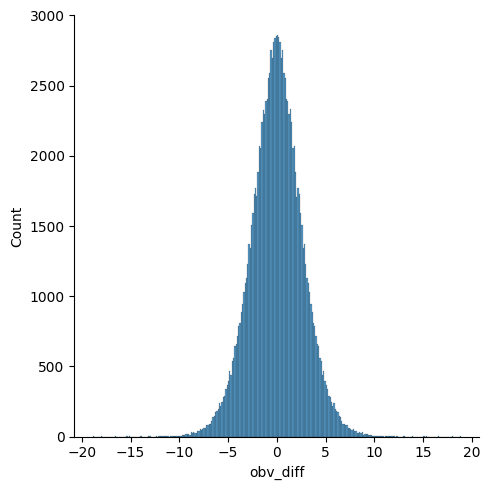

In [8]:
import seaborn as sns
sns.displot(gvecs.obv_diff)





In [14]:

games = create_lineup_checklist(stf_schedule)
games = games.drop_duplicates(subset=['match_id']).drop(columns=['team_id'])

row = game_list.iloc[0]
minutes = pd.read_csv(row['minutes_path'])


In [16]:
row['minutes_path']

'D://_G_Street/player_model\\playing_time/8/1/9949.csv'

In [15]:

minutes


,match_id,competition_id,season_id,team_id,jersey_number,player_id,player_name,position_id,position_name,start_time,end_time,sub_type,playing_time,team_formation
0,9949,8,1,163,1.0,7309,Axel Kacou,1,Goalkeeper,0.000000,94.850000,None,94.850000,4231.0
1,9949,8,1,163,24.0,7324,Jonathan Gradit,2,Right Back,0.000000,94.850000,None,94.850000,4231.0
2,9949,8,1,163,5.0,7484,Thibaut Cillard,3,Right Center Back,0.000000,94.850000,None,94.850000,4231.0
3,9949,8,1,163,25.0,7482,Ibrahim Cissé,5,Left Center Back,0.000000,94.850000,None,94.850000,4231.0
4,9949,8,1,163,12.0,7316,Florian Miguel,6,Left Back,0.000000,94.850000,None,94.850000,4231.0
5,9949,8,1,163,28.0,7489,Florian Adel Makhedjouf,13,Right Center Midfield,0.000000,70.283333,nan_off,70.283333,4231.0
6,9949,8,1,163,3.0,7486,Cyriaque Louvion,15,Left Center Midfield,0.000000,94.850000,None,94.850000,4231.0
7,9949,8,1,163,27.0,7320,Hameur Bouazza,17,Right Wing,0.000000,63.450000,nan_off,63.450000,4231.0
8,9949,8,1,163,7.0,7325,Haris Belkebla,19,Center Attacking Midfield,0.000000,94.850000,None,94.850000,4231.0
9,9949,8,1,163,10.0,7335,Ibrahima Tandia,21,Left Wing,0.000000,94.850000,None,94.850000,4231.0
